## Libraries

In [1]:
# base
import pandas as pd
import numpy as np
import sqlite3

# Spatial
import geopandas as gpd
import libpysal as lps
import mapclassify as mc
import esda
import spreg
import pysal as ps

# Plot
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\libpysal\examples\remotes.py:26: UserWarning: Remote data sets not available. Check connection.
  warnings.warn("Remote data sets not available. Check connection.")


## Load data

In [2]:
df_shapes = gpd.read_file("data/loan_geodata.gpkg", layer='shapes', driver="GPKG")
df_points = gpd.read_file("data/loan_geodata.gpkg", layer='points', driver="GPKG")

In [3]:
df_shapes.columns

Index(['address', 'approval_year', 'approved_amt', 'bank_id', 'bank_label',
       'business_flag', 'charged_off_amt', 'city', 'days_to_disbursement',
       'def_flag', 'disbursed_amt', 'disbursement_year', 'employee_num',
       'franchise_flag', 'guaranteed_amt', 'guaranteed_pct', 'industry_id',
       'industry_label', 'jobs_created_num', 'jobs_retained_num', 'loan_term',
       'page_application_flag', 'real_estate_flag', 'recession_flag',
       'revolting_flag', 'same_state_flag', 'state', 'urban_id', 'zip', 'lat',
       'lon', 'geometry'],
      dtype='object')

## Weights matrix

- <http://darribas.org/gds_scipy16/ipynb_md/03_spatial_weights.html>
- <https://pysal.org/libpysal/notebooks/weights.html>

1. Contiguity Weights - neighbous are determined based on common borders
- Queen Weights: A commonly-used type of weight is a queen contigutiy weight, which reflects adjacency relationships as a binary indicator variable denoting whether or not a polygon shares an edge or a vertex with another polygon.
- Rook Weights: Rook weights are another type of contiguity weight, but consider observations as neighboring only when they share an edge. The rook neighbors of an observation may be different than its queen neighbors, depending on how the observation and its nearby polygons are configured.
- Bishop Weights: In theory, a "Bishop" weighting scheme is one that arises when only polygons that share vertexes are considered to be neighboring. Bishop weights entail all Queen neighbor pairs that are not also Rook neighbors.

2. Distance Weights - neighbous are determined based on how far away they are
- KNN defined weights: Creates nearest neighbor weights matrix based on k nearest neighbors.
- Kernel W: Kernel Weights are continuous distance-based weights that use kernel densities to define the neighbor relationship. Typically, they estimate a bandwidth, which is a parameter governing how far out observations should be considered neighboring. Then, using this bandwidth, they evaluate a continuous kernel function to provide a weight between 0 and 1.
- Distance Thresholds: Spatial weights based on distance band.


In [4]:
W = lps.weights.KNN.from_dataframe(df_points, k=10)
W.transform = 'r' #normalise
print("Percentage of non-zero weights: ", W.pct_nonzero)

Percentage of non-zero weights:  0.17173278378842521


In [5]:
def weights_plot(df, weights):
    fig, ax = plt.subplots(figsize=(20,15), subplot_kw={'aspect':'equal'})
    # shapes
    df.plot(edgecolor='grey', facecolor='w', ax=ax)
    # Weights connections
    f,ax = weights.plot(df, ax=ax,
            edge_kws=dict(color='r', linestyle=':', linewidth=1),
            node_kws=dict(marker=''))
    
    ax.set_axis_off()
    plt.show()

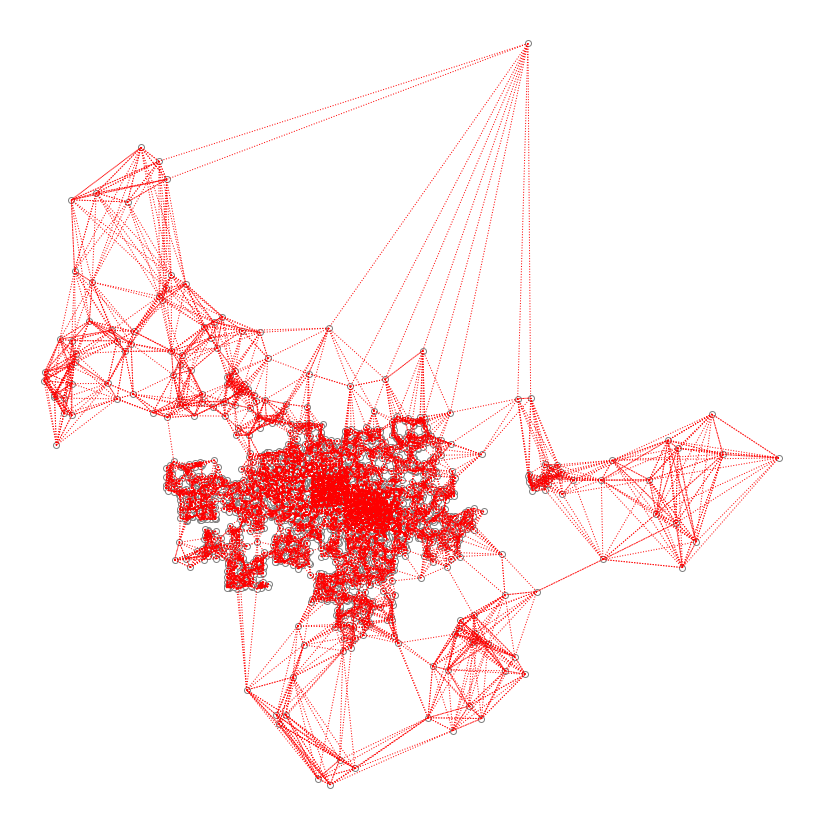

In [6]:
weights_plot(df_points, W)

## Spatial Autocorrelation

The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.

#### Analysing all variables

In [7]:
for columns in df_points.select_dtypes(include=np.number).columns:
    morans_I_stat = esda.Moran(df_points[columns], W)
    print('==========================================',
          '\nColumn: ',columns,
          '\nMorans I stat value: ', morans_I_stat.I, 
          '\nMorans p-value: ', morans_I_stat.p_sim)

Column:  approval_year 
Morans I stat value:  0.01735306510854883 
Morans p-value:  0.002
Column:  approved_amt 
Morans I stat value:  0.03128593667617554 
Morans p-value:  0.001
Column:  bank_id 
Morans I stat value:  0.019713317037093996 
Morans p-value:  0.001
Column:  business_flag 
Morans I stat value:  0.014927225211232891 
Morans p-value:  0.006
Column:  charged_off_amt 
Morans I stat value:  0.012721951369650382 
Morans p-value:  0.016
Column:  days_to_disbursement 
Morans I stat value:  0.0016028086073164875 
Morans p-value:  0.336
Column:  def_flag 
Morans I stat value:  0.05523226441741355 
Morans p-value:  0.001
Column:  disbursed_amt 
Morans I stat value:  0.03141693208803694 
Morans p-value:  0.001
Column:  disbursement_year 
Morans I stat value:  0.015656905104812227 
Morans p-value:  0.004
Column:  employee_num 
Morans I stat value:  0.02107119532405588 
Morans p-value:  0.001
Column:  franchise_flag 
Morans I stat value:  0.004177444386963272 
Morans p-value:  0.232
Co

#### Selecting target variable

In [8]:
target_var = "def_flag"

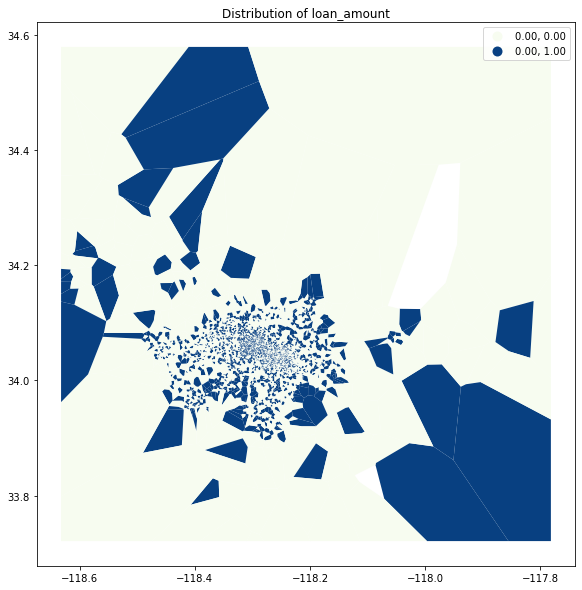

In [9]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})

df_shapes.plot(column=target_var, scheme='Quantiles', k=2, cmap='GnBu', legend=True, ax=ax)
plt.title("Distribution of {}".format("loan_amount"))
plt.show()

In [10]:
morans_I_stat = esda.Moran(df_points[target_var], W)

In [11]:
print('Morans I stat value: ', morans_I_stat.I, 
      '\nMorans p-value: ', morans_I_stat.p_sim)

Morans I stat value:  0.05523226441741355 
Morans p-value:  0.001


In [12]:
#  KDEplot
def kde_plot(morans_I_stat):
    sns.kdeplot(morans_I_stat.sim, shade=True)
    plt.vlines(morans_I_stat.sim, 0, 0.5)
    plt.vlines(morans_I_stat.I, 0, 10, 'r')
    plt.xlim([-0.15, 0.15])
    
    plt.title("KDE plot for Moran`s I test")
    plt.show()

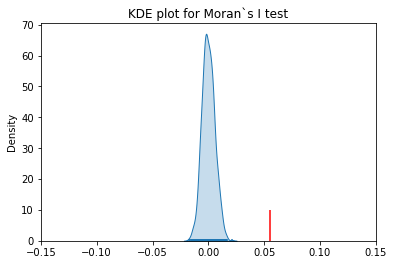

In [13]:
kde_plot(morans_I_stat)

#### Local Autocorrelation Statistics

In [14]:
def moran_scatterplot(df, W, target_var):
    
    # Spatial lag:
    target_lag = lps.weights.lag_spatial(W, target_var)
    
    # local Moran`s stat:
    local_morans_I_stat = esda.Moran_Local(target_var, W)
    
    # Moran Scatterplot
    fig, ax = plt.subplots(1, figsize=(9, 9))
    
    # Statistically significant LISA values:
    sigs = target_var[local_morans_I_stat.p_sim <= .001]
    W_sigs = target_lag[local_morans_I_stat.p_sim <= .001]
    plt.plot(sigs, W_sigs, '.', color='firebrick', label = 'p-value <= .001', marker='s')
    
    # Statistically insignificant LISA values:
    insigs = target_var[local_morans_I_stat.p_sim > .001]
    W_insigs = target_lag[local_morans_I_stat.p_sim > .001]
    plt.plot(insigs, W_insigs, '.k', alpha=.2, label = 'p-value > .001', marker='^')
    
    # dashed vertical at mean of the target var
    plt.vlines(target_var.mean(), target_lag.min(), target_lag.max(), linestyle='--')
    
    # dashed horizontal at mean of the lagged target var
    plt.hlines(target_lag.mean(), target_var.min(), target_var.max(), linestyle='--')
    
    # Fitted line:
    b,a = np.polyfit(target_var, target_lag, 1)
    plt.plot(target_var, a + b*target_var, 'r')
    
    plt.title('Moran Scatterplot')
    plt.legend()
    plt.ylabel('Spatial Lag of target Variable')
    plt.xlabel('Target Variable')
    plt.show()

![title](https://slideplayer.com/slide/4747335/15/images/16/Quadrants+of+Moran+Scatterplot.jpg)

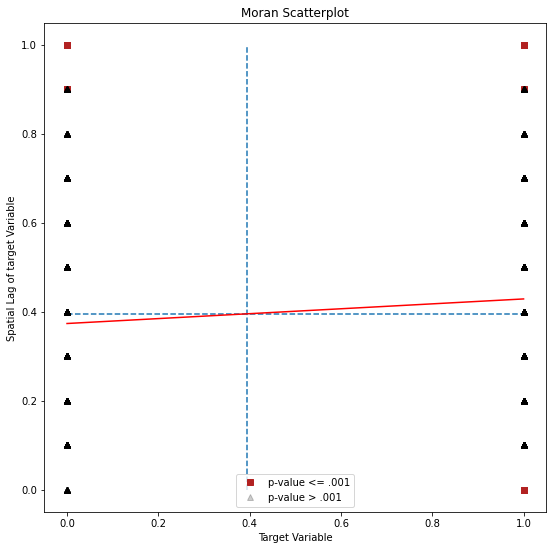

In [15]:
moran_scatterplot(df_points, W, df_points[target_var])

## Hot/cold spot analysis

In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let's compute a local Moran statistic for the same d

The Hot Spot Analysis tool calculates the Getis-Ord Gi* statistic (pronounced G-i-star) for each feature in a dataset. The resultant z-scores and p-values tell you where features with either high or low values cluster spatially. This tool works by looking at each feature within the context of neighboring features. A feature with a high value is interesting but may not be a statistically significant hot spot. To be a statistically significant hot spot, a feature will have a high value and be surrounded by other features with high values as well. The local sum for a feature and its neighbors is compared proportionally to the sum of all features; when the local sum is very different from the expected local sum, and when that difference is too large to be the result of random chance, a statistically significant z-score results.



In [16]:
def hot_cold_plot(df, W, target_var):
    # Spatial lag:
    target_lag = lps.weights.lag_spatial(W, target_var)

    # local Moran`s stat:
    local_morans_I_stat = esda.Moran_Local(target_var, W)
    
    # Defining points:
    sig = 1 * (local_morans_I_stat.p_sim < 0.05)
    hotspot = 1 * (sig * local_morans_I_stat.q==1)
    coldspot = 3 * (sig * local_morans_I_stat.q==3)
    doughnut = 2 * (sig * local_morans_I_stat.q==2)
    diamond = 4 * (sig * local_morans_I_stat.q==4)
    spots = hotspot + coldspot + doughnut + diamond
    
    # Labels and colors
    spot_labels = [ '0: No data', '1: hot spot (Q1)', '2: doughnut (Q2)', '3: cold spot (Q3)', '4: diamond (Q4)']
    labels = [spot_labels[i] for i in spots]
    hmap = colors.ListedColormap([ 'lightgrey', 'red', 'cyan', 'blue', 'magenta'])
    
    # Plot
    f, ax = plt.subplots(1, figsize=(15, 15))
    df.assign(cl=labels).plot(column='cl', categorical=True,
                              k=2, cmap=hmap, linewidth=0.1, ax=ax,
                              edgecolor='white', legend=True)
    
    ax.set_axis_off()
    plt.show()

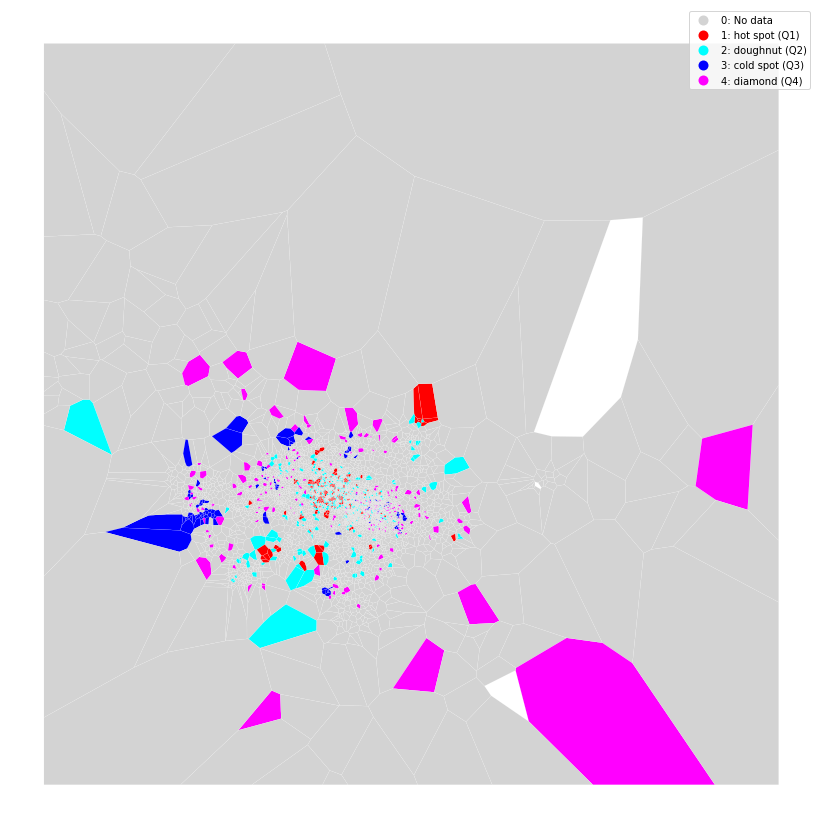

In [17]:
hot_cold_plot(df_shapes, W, df_points[target_var])

## Spatial regression

http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html

https://github.com/pysal/spreg/blob/master/notebooks/GM_Lag_example.ipynb

https://github.com/pysal/spreg/blob/master/notebooks/Panel_FE_example.ipynb

(!) https://geographicdata.science/book/notebooks/11_regression.html

In [18]:
# Independent variable names
column_list = df_points.select_dtypes(include=np.number).columns.to_list()
remove_list = [target_var, 'lat','lon', 'approval_year','disbursement_year',
               'approved_amt','disbursed_amt', 'guaranteed_amt', 'real_estate_flag']
x_names = list(set(column_list) - set(remove_list))
print(x_names)

['industry_id', 'same_state_flag', 'page_application_flag', 'employee_num', 'revolting_flag', 'days_to_disbursement', 'jobs_created_num', 'loan_term', 'bank_id', 'franchise_flag', 'charged_off_amt', 'jobs_retained_num', 'business_flag', 'recession_flag', 'guaranteed_pct']


#### 1. ORDINARY LEAST SQUARES

The model to estimate is:

$$ y = X \beta + \epsilon $$

In [19]:
m1 = spreg.OLS(df_points[target_var].values, 
               df_points[x_names].values, 
               name_x=x_names, 
               name_y=target_var, 
               name_w="KNN", 
               name_ds="LA")
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :          LA
Weights matrix      :        None
Dependent Variable  :    def_flag                Number of Observations:        5823
Mean dependent var  :      0.3934                Number of Variables   :          16
S.D. dependent var  :      0.4886                Degrees of Freedom    :        5807
R-squared           :      0.4932
Adjusted R-squared  :      0.4919
Sum squared residual:     704.241                F-statistic           :    376.7701
Sigma-square        :       0.121                Prob(F-statistic)     :           0
S.E. of regression  :       0.348                Log likelihood        :   -2112.079
Sigma-square ML     :       0.121                Akaike info criterion :    4256.157
S.E of regression ML:      0.3478                Schwarz criterion     :    4362.870

-----------------------------------------------------------------------------

#### 2. Spatially lagged exogenous regressors (WX)

The model to estimate is:

$$ y = X \beta + WX \gamma + \epsilon $$

In [20]:
# Creating a weights matrix for lagged x
w_x = lps.weights.KNN.from_array(df_points[['lon', 'lat']].values, k=10)

# Lagging independent variables
x_lag = df_points[x_names+[target_var]].assign(w_x = lps.weights.lag_spatial(w_x, df_points[target_var].values)).drop(target_var, axis=1)

In [21]:
m2 = spreg.OLS(df_points[target_var].values, 
               x_lag.values, 
               w=W, 
               name_x=x_names, name_y=target_var, 
               name_w="KNN", 
               name_ds="LA")
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :          LA
Weights matrix      :         KNN
Dependent Variable  :    def_flag                Number of Observations:        5823
Mean dependent var  :      0.3934                Number of Variables   :          17
S.D. dependent var  :      0.4886                Degrees of Freedom    :        5806
R-squared           :      0.4995
Adjusted R-squared  :      0.4981
Sum squared residual:     695.555                F-statistic           :    362.1021
Sigma-square        :       0.120                Prob(F-statistic)     :           0
S.E. of regression  :       0.346                Log likelihood        :   -2075.949
Sigma-square ML     :       0.119                Akaike info criterion :    4185.898
S.E of regression ML:      0.3456                Schwarz criterion     :    4299.281

-----------------------------------------------------------------------------

#### 3. Spatially lagged endogenous regressors (WY)

Let's estimate a spatial lag panel model with fixed effects:

$$
y = \rho Wy + X\beta + \mu_i + e
$$

In [22]:
m3 = spreg.GM_Lag(df_points[target_var].values, 
                  df_points[x_names].values, 
                  w=W, 
                  spat_diag=True, 
                  name_x=x_names, name_y=target_var, 
                  name_w="KNN", 
                  name_ds="LA")
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :          LA
Weights matrix      :         KNN
Dependent Variable  :    def_flag                Number of Observations:        5823
Mean dependent var  :      0.3934                Number of Variables   :          17
S.D. dependent var  :      0.4886                Degrees of Freedom    :        5806
Pseudo R-squared    :      0.4992
Spatial Pseudo R-squared:  0.4964

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.4420765       0.0418625      10.5602137       0.0000000
         industry_id      -0.0009895       0.0003280      -3.0169624       0.0025532
     same_state_flag      -0.1508524       0.0121626     -1

In [23]:
# using second order spatial lags for the instruments, set w_lags = 2
m3_2 = spreg.GM_Lag(df_points[target_var].values, 
                    df_points[x_names].values, 
                    w=W, 
                    w_lags=2, 
                    spat_diag=True, 
                    name_x=x_names, name_y=target_var, 
                    name_w="KNN", 
                    name_ds="LA")
print(m3_2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :          LA
Weights matrix      :         KNN
Dependent Variable  :    def_flag                Number of Observations:        5823
Mean dependent var  :      0.3934                Number of Variables   :          17
S.D. dependent var  :      0.4886                Degrees of Freedom    :        5806
Pseudo R-squared    :      0.4992
Spatial Pseudo R-squared:  0.4964

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.4343948       0.0418272      10.3854540       0.0000000
         industry_id      -0.0009954       0.0003280      -3.0349283       0.0024059
     same_state_flag      -0.1513144       0.0121623     -1

#### 4. Spatially lagged error term (Wv)

Now, let's estimate a spatial error panel model with fixed effects:

$$
y = X\beta + \mu_i + v
$$
where

$$
v = \lambda W v + e
$$

In [24]:
m4 = spreg.GM_Error_Het(df_points[target_var].values, 
                        df_points[x_names].values, 
                        w=W,  
                        name_x=x_names, name_y=target_var, 
                        name_w="KNN", 
                        name_ds="LA")
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :          LA
Weights matrix      :         KNN
Dependent Variable  :    def_flag                Number of Observations:        5823
Mean dependent var  :      0.3934                Number of Variables   :          16
S.D. dependent var  :      0.4886                Degrees of Freedom    :        5807
Pseudo R-squared    :      0.4932
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.5150746       0.0547620       9.4056974       0.0000000
         industry_id      -0.0009561       0.0003486      -2.7426074       0.00

#### 5. Regimes

Now, let's estimate a spatial error panel model with fixed effects:

$$
y = \alpha_r + X\beta + e
$$

Econometrically speaking, what the neighborhood FEs we have introduced imply is that, instead of comparing all house prices across San Diego as equal, we only derive variation from within each postcode. Remember that the interpretation of βk is the effect of variable k, given all the other explanatory variables included remain constant. By including a single variable for each area, we are effectively forcing the model to compare as equal only house prices that share the same value for each variable; or, in other words, only houses located within the same area. Introducing FE affords a higher degree of isolation of the effects of the variables we introduce in the model because we can control for unobserved effects that align spatially with the distribution of the FE introduced (by postcode, in our case).

In [25]:
# PySAL implementation
m5 = spreg.OLS_Regimes(df_points[target_var].values, 
                       df_points[x_names].values,
                       df_points['zip'].tolist(),
                       constant_regi='many',
                       cols2regi=[False]*len(x_names),
                       regime_err_sep=False,
                       name_y=target_var, 
                       name_x=x_names,
                       name_w="KNN", 
                       name_ds="LA")
print(m5.summary)

C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\spreg\diagnostics.py:585: ComplexWarning: Casting complex values to real discards the imaginary part
  ci_result = sqrt(max_eigval / min_eigval)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :          LA
Weights matrix      :        None
Dependent Variable  :    def_flag                Number of Observations:        5823
Mean dependent var  :      0.3934                Number of Variables   :         189
S.D. dependent var  :      0.4886                Degrees of Freedom    :        5634
R-squared           :      0.5211
Adjusted R-squared  :      0.5052
Sum squared residual:     665.436                F-statistic           :     32.6142
Sigma-square        :       0.118                Prob(F-statistic)     :           0
S.E. of regression  :       0.344                Log likelihood        :   -1947.062
Sigma-square ML     :       0.114                Akaike info criterion :    4272.124
S.E of regression ML:      0.3380                Schwarz criterion     :    5532.673

---------------------------------------------------------

#### Prediction performance of spatial models

In [28]:
m1_pred = m1.predy
m2_pred = m2.predy
m3_pred = m3.predy
m3_2_pred = m3_2.predy
m4_pred = m4.predy
m5_pred = m5.predy

In [29]:
print(m1_pred.min(), m1_pred.max())
print(m2_pred.min(), m2_pred.max())
print(m3_pred.min(), m3_pred.max())
print(m3_2_pred.min(), m3_2_pred.max())
print(m4_pred.min(), m4_pred.max())
print(m5_pred.min(), m5_pred.max())

-0.8890637128712795 5.071318604436442
-0.8734812790294446 5.001077174319063
-0.8745079626898884 5.004718616377556
-0.8729130711228537 4.997421173237077
-0.8773208859344483 5.049895028575818
-0.8088038439492582 4.8307044538223485


In [26]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'OLS':   mse(df_points[target_var], m1.predy.flatten()),
                  'OLS+W': mse(df_points[target_var], m2.predy.flatten()),
                  'Lag':   mse(df_points[target_var], m3.predy_e)})
mses.sort_values()

OLS+W    0.119450
Lag      0.120184
OLS      0.120941
dtype: float64

In [31]:
from scipy.special import logit

In [32]:
target_var_logit = logit(df_points[target_var].values)